# Scraping Tweets with playwright

In [1]:
"""
data_preprocessing_01.py

This script preprocesses raw tweet data for sentiment analysis.
It includes cleaning functions, tokenization, sentiment scoring,
and saves the processed dataset for model training.
"""

# Standard Library Imports
import datetime as dt
import random
import re
import asyncio
from datetime import datetime, timedelta
import os

# Data Handling
import pandas as pd
import yfinance as yf

# Text Processing & Sentiment Analysis
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
import preprocessor

# Visualization
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import plotly.graph_objects as go
import kaleido

# Web Scraping
import nest_asyncio
from playwright.async_api import async_playwright

# Apply nest_asyncio patch for asyncio inside Jupyter
nest_asyncio.apply()

In [2]:
# Configuration
START_DATE = "2024-06-01"
END_DATE = "2025-04-01"

In [ ]:
# Manual Login

async def login_and_save_storage():
    """
    Logs into Twitter manually using Playwright and saves session data.

    Opens a non-headless browser for manual login, then stores authentication
    credentials in 'twitter_auth.json'.

    Returns:
    None
    """
    async with async_playwright() as pw:
        browser = await pw.chromium.launch(headless=False)
        context = await browser.new_context()
        page = await context.new_page()

        await page.goto("https://twitter.com/login")
        print("Log in manually in the browser window...")

        await asyncio.sleep(70)  # Time to log in

        await context.storage_state(path="twitter_auth.json")
        print("Session saved to twitter_auth.json")
        await browser.close()


asyncio.run(login_and_save_storage())

In [ ]:
# Scraping tweets of Netflix and Amazon

nest_asyncio.apply()


async def scrape_twitter(
    stock, start_date, end_date, accounts, retries=3, timeout=120000
):
    """
    Scrapes tweets about a stock from specific accounts within a date range.

    Args:
        stock (str): Stock symbol or keyword.
        start_date (str): Start date (YYYY-MM-DD).
        end_date (str): End date (YYYY-MM-DD).
        accounts (list): Twitter accounts to filter.
        retries (int, optional): Retry attempts. Defaults to 3.
        timeout (int, optional): Page load timeout (ms). Defaults to 120000.

    Returns:
        None
    """
    async with async_playwright() as pw:
        browser = await pw.chromium.launch(headless=False)
        context = await browser.new_context(storage_state="twitter_auth.json")
        page = await context.new_page()

        all_tweets = []  # Store tweets from all accounts

        for account in accounts:
            print(
                f"🔄 Collecting tweets for {account} from {start_date} to {end_date}"
            )
            search_query = f"{stock} from:{account} since:{start_date} until:{end_date} lang:en"
            final_url = f"https://twitter.com/search?q={search_query.replace(' ', '%20')}&src=typed_query&f=live"

            print(f"🔍 Searching {account}: {final_url}")
            await page.goto(final_url, timeout=timeout)

            # Click "Latest" tab explicitly after search loads
            try:
                await page.wait_for_selector("text=Latest", timeout=10000)
                await page.click("text=Latest")
                print("✅ Clicked 'Latest' tab.")
            except Exception as e:
                print(f"⚠️ 'Latest' tab click skipped - error: {e}")

            # Ensure tweets load before scraping, but handle cases where no tweets exist
            try:
                await page.wait_for_selector(
                    "article[aria-labelledby], article", timeout=15000
                )  # note that twitter frequently changes DOM structure
            except:
                print(f"⚠️ No tweets found for {account}. Skipping...")
                all_tweets.append(
                    {
                        "tweet": "No tweets found",
                        "date": "N/A",
                        "account": account,
                    }
                )
                continue  # Skip to the next account

            # Fetch initial tweets
            tweet_elements = await page.query_selector_all(
                "article[aria-labelledby], article"
            )
            print(f"🔍 Found {len(tweet_elements)} tweets before scrolling.")

            # Scroll dynamically **only if tweets exist**
            if tweet_elements:
                previous_tweet_count = 0
                scroll_attempts = 0

                while scroll_attempts < 50:  # Avoid infinite scrolling
                    await page.evaluate(
                        "window.scrollBy(0, 2000 + Math.random() * 500)"
                    )
                    await asyncio.sleep(random.uniform(2, 5))

                    tweet_elements = await page.query_selector_all(
                        "article[aria-labelledby], article"
                    )
                    current_tweet_count = len(tweet_elements)

                    if (
                        current_tweet_count == previous_tweet_count
                    ):  # No new tweets loaded
                        print(
                            f"✅ No new tweets detected for {account}, stopping scroll."
                        )
                        break

                    previous_tweet_count = current_tweet_count
                    scroll_attempts += 1
            else:
                print(
                    f"⚠️ No tweets detected initially for {account}, skipping scrolling."
                )

            # Extract tweets
            for tweet in tweet_elements:
                try:
                    time_element = await tweet.query_selector("time")
                    date = (
                        await time_element.get_attribute("datetime")
                        if time_element
                        else "Unknown"
                    )

                    text_element = await tweet.query_selector("div[lang]")
                    text = (
                        await text_element.inner_text()
                        if text_element
                        else "Unknown"
                    )

                    handles = await tweet.query_selector_all("a")
                    username = "Unknown"
                    for h in handles:
                        handle_text = await h.inner_text() or await h.evaluate(
                            "(el) => el.textContent"
                        )
                        if handle_text.startswith("@"):
                            username = handle_text
                            break

                    # Append all tweets without filtering by "$NFLX"
                    all_tweets.append(
                        {
                            "tweet": text.strip(),
                            "date": date,
                            "account": username,
                        }
                    )

                except Exception as e:
                    print(f"⚠️ Error processing tweet: {e}")

        await browser.close()
        return pd.DataFrame(all_tweets).drop_duplicates(
            subset=["tweet"]
        )  # Remove duplicate tweets


async def collect_tweets(
    stock, start_date, end_date, accounts, filename_prefix
):
    current_date = datetime.strptime(start_date, "%Y-%m-%d")
    end_date_dt = datetime.strptime(end_date, "%Y-%m-%d")
    all_tweets = pd.DataFrame()
    weeks_processed = 0

    while current_date < end_date_dt:
        week_end = min(current_date + timedelta(days=7), end_date_dt)
        week_start_str = current_date.strftime("%Y-%m-%d")
        week_end_str = week_end.strftime("%Y-%m-%d")
        print(f"🔄 Collecting tweets from {week_start_str} to {week_end_str}")

        weekly_df = await scrape_twitter(
            stock, week_start_str, week_end_str, accounts
        )
        all_tweets = pd.concat([all_tweets, weekly_df], ignore_index=True)
        current_date = week_end
        weeks_processed += 1

        # Save progress every 4 weeks
        if weeks_processed % 4 == 0:
            checkpoint_file = (
                f"{filename_prefix}_checkpoint_{week_start_str}.csv"
            )
            all_tweets.to_csv(checkpoint_file, index=False)
            print(f"💾 Saved intermediate results to {checkpoint_file}")

    return all_tweets


async def main():
    accounts = [
        "cnbc",
        "Stocktwits",
        "WSJ",
        "reuters",
        "forbes",
        "RobinJPowell",
        "WSJDealJournal",
        "Benzinga",
        "EventDrivenMgr",
        "SeekingAlpha",
        "WSJmarkets",
        "Business",
        "tradingguru",
        "marketcurrents",
        "financialtimes",
        "elonmusk",
        "SpiegelPeter",
        "BillGates",
        "bespokeinvest",
        "AlphaTrends",
        "StockMKTNewz",
        "PeterLBrandt",
        "JPMorgan",
        "SvenHenrich",
        "Bloomberg",
    ]

    netflix_tweets = await collect_tweets(
        "Netflix OR $NFLX", START_DATE, END_DATE, accounts, "netflix"
    )
    netflix_tweets.to_csv("netflix_all_tweets.csv", index=False)
    print(
        f"✅ Saved {len(netflix_tweets)} tweets for Netflix to netflix_all_tweets.csv"
    )

    amazon_tweets = await collect_tweets(
        "Amazon OR $AMZN", START_DATE, END_DATE, accounts, "amazon"
    )
    amazon_tweets.to_csv("amazon_all_tweets.csv", index=False)
    print(
        f"✅ Saved {len(amazon_tweets)} tweets for Amazon to amazon_all_tweets.csv"
    )


asyncio.run(main())

In [3]:
# Get project root dynamically
base_dir = os.path.abspath(os.path.join(os.getcwd(), ".."))

# Construct relative paths
netflix_df = pd.read_csv(os.path.join(base_dir, "data", "netflix_all_tweets.csv"))
amazon_df = pd.read_csv(os.path.join(base_dir, "data", "amazon_all_tweets.csv"))

# drop duplicates
netflix_df = netflix_df.drop_duplicates(subset="tweet", keep="first")
amazon_df = amazon_df.drop_duplicates(subset="tweet", keep="first")

print(netflix_df.shape)
print(amazon_df.shape)

(584, 3)
(1062, 3)


# **Tweet Preprocessing**

In [4]:
# Combining both dataframes into one with adding a column of netflix / amzn
amazon_df["stock"] = "amazon"
netflix_df["stock"] = "netflix"
tweet_df = pd.concat([amazon_df, netflix_df])
tweet_df["date"] = pd.to_datetime(tweet_df["date"]).dt.date
tweet_df = tweet_df[tweet_df["tweet"] != "No tweets found"]  # dropping
tweet_df

,tweet,date,account,stock
0,"Trump sued over purge at NLRB, regulator targe...",2025-02-05,@CNBC,amazon
1,Amazon announces hardware event for Feb. 26 as...,2025-02-05,@CNBC,amazon
2,Amazon to face legal action after Quebec wareh...,2025-02-04,@CNBC,amazon
3,Here are Monday's biggest analyst calls: Nvidi...,2025-02-03,@CNBC,amazon
4,Earnings playbook: Your guide to the busiest w...,2025-02-02,@CNBC,amazon
...,...,...,...,...
579,"RT Congrats to America! A sexual assaulter, dr...",2025-01-25,@TradingGuru,netflix
580,$NFLX $AAPL $GM - Notable analyst calls this w...,2025-01-25,@MarketCurrents,netflix
581,Can I be player 230,2025-01-30,@StockMKTNewz,netflix
582,Netflix $NFLX just confirmed the final season ...,2025-01-30,@StockMKTNewz,netflix


In [5]:
# Download NLTK resources
nltk.download("punkt")
nltk.download("wordnet")

lemmatizer = WordNetLemmatizer()

# Define financial stopwords that should NOT be removed
financial_stopwords = {
    "up",
    "down",
    "bullish",
    "bearish",
    "profit",
    "loss",
    "growth",
    "decline",
}


def preprocess_pipeline(tweet):
    """
    Preprocesses a tweet by removing unwanted elements, normalizing text,
    tokenizing, and applying lemmatization with consideration for financial stopwords.

    Parameters:
        tweet (str): The raw tweet text.

    Returns:
        str: The preprocessed tweet as a single string with cleaned and normalized text.
    
    Steps:
        - Removes URLs, mentions, hashtags, emojis, reserved words, and stock symbols.
        - Removes punctuation and numbers.
        - Normalizes repeated characters.
        - Converts the text to lowercase.
        - Tokenizes the text into words and removes stopwords (except financial stopwords).
        - Applies lemmatization to the tokens.
    """
    tweet = preprocessor.clean(str(tweet))
    tweet = re.sub(r"[$]+[a-zA-Z]+", "", tweet)
    tweet = re.sub(r"[^a-zA-Z\s]", "", tweet)
    pattern = re.compile(r"(.)\1{2,}")
    tweet = pattern.sub(r"\1\1", tweet)
    tweet = tweet.lower()

    tokens = word_tokenize(tweet)
    stop_words = stopwords.words("english")
    tokens = [
        lemmatizer.lemmatize(word)
        for word in tokens
        if word not in stop_words or word in financial_stopwords
    ]

    return " ".join(tokens)

# Apply pipeline to all tweets
tweet_df["processed_tweet"] = tweet_df["tweet"].apply(preprocess_pipeline)

# Preview processed tweets
print(tweet_df.head())

[nltk_data] Downloading package punkt to /home/ilse/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /home/ilse/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


                                               tweet        date account  \
0  Trump sued over purge at NLRB, regulator targe...  2025-02-05   @CNBC   
1  Amazon announces hardware event for Feb. 26 as...  2025-02-05   @CNBC   
2  Amazon to face legal action after Quebec wareh...  2025-02-04   @CNBC   
3  Here are Monday's biggest analyst calls: Nvidi...  2025-02-03   @CNBC   
4  Earnings playbook: Your guide to the busiest w...  2025-02-02   @CNBC   

    stock                                    processed_tweet  
0  amazon  trump sued purge nlrb regulator targeted space...  
1  amazon  amazon announces hardware event feb race relea...  
2  amazon  amazon face legal action quebec warehouse clos...  
3  amazon  monday biggest analyst call nvidia apple tesla...  
4  amazon  earnings playbook guide busiest week season in...  


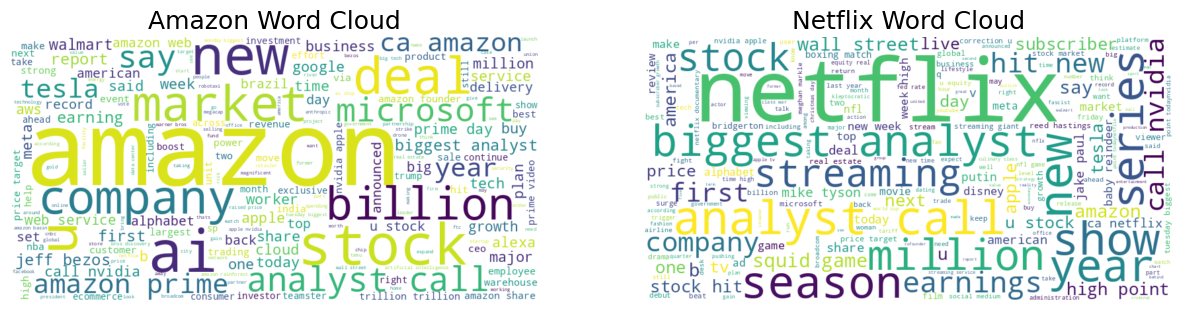

In [6]:
# Filter tweets for Amazon and Netflix separately
amazon_tweets = " ".join(
    tweet_df[tweet_df["stock"] == "amazon"]["processed_tweet"]
)
netflix_tweets = " ".join(
    tweet_df[tweet_df["stock"] == "netflix"]["processed_tweet"]
)

# Generate word clouds
amazon_wordcloud = WordCloud(
    background_color="white", width=800, height=400
).generate(amazon_tweets)

netflix_wordcloud = WordCloud(
    background_color="white", width=800, height=400
).generate(netflix_tweets)

# Display word clouds side by side
fig, ax = plt.subplots(1, 2, figsize=(15, 7))

ax[0].imshow(amazon_wordcloud, interpolation="bilinear")
ax[0].set_title("Amazon Word Cloud", fontsize=18)
ax[0].axis("off")

ax[1].imshow(netflix_wordcloud, interpolation="bilinear")
ax[1].set_title("Netflix Word Cloud", fontsize=18)
ax[1].axis("off")

plt.show()

# **VADER - Sentiment Analysis**

In [7]:
analyser = SentimentIntensityAnalyzer()


# Initialize Sentiment Intensity Analyzer
analyser = SentimentIntensityAnalyzer()


def get_sentiment_scores(text):
    """
    Computes sentiment scores using VaderSentiment.
    Args:
        text (str): The processed tweet text.
    Returns:
        pd.Series: A pandas Series containing neg, neu, pos, and compound scores.
    """
    scores = analyser.polarity_scores(text)
    return pd.Series(
        [scores["neg"], scores["neu"], scores["pos"], scores["compound"]],
        index=["neg", "neu", "pos", "compound"],
    )


tweet_df[["neg", "neu", "pos", "compound"]] = (
    tweet_df["processed_tweet"].apply(get_sentiment_scores)
)

# Display sample results
tweet_df.head()

,tweet,date,account,stock,processed_tweet,neg,neu,pos,compound
0,"Trump sued over purge at NLRB, regulator targe...",2025-02-05,@CNBC,amazon,trump sued purge nlrb regulator targeted space...,0.0,0.825,0.175,0.1779
1,Amazon announces hardware event for Feb. 26 as...,2025-02-05,@CNBC,amazon,amazon announces hardware event feb race relea...,0.0,0.825,0.175,0.1779
2,Amazon to face legal action after Quebec wareh...,2025-02-04,@CNBC,amazon,amazon face legal action quebec warehouse clos...,0.0,0.714,0.286,0.2960
3,Here are Monday's biggest analyst calls: Nvidi...,2025-02-03,@CNBC,amazon,monday biggest analyst call nvidia apple tesla...,0.0,0.848,0.152,0.2449
4,Earnings playbook: Your guide to the busiest w...,2025-02-02,@CNBC,amazon,earnings playbook guide busiest week season in...,0.0,0.841,0.159,0.1779


In [8]:
# Defining classes
def analyse_sentiment(compound):
    """
    Classifies sentiment based on the compound score from Vader.

    Args:
        compound (float): The compound sentiment score (ranges from -1 to 1).

    Returns:
        str: A sentiment label ('Positive_VADER', 'Neutral_VADER', 'Negative_VADER').
    """
    if compound > 0:
        return "Positive_VADER"
    if compound == 0:
        return "Neutral_VADER"
    return "Negative_VADER"  # Simplified: No need for `if compound < 0`


# Apply the funtion on Polarity column and add the results into a new column
tweet_df["class_VADER"] = tweet_df["compound"].apply(analyse_sentiment)

print(tweet_df.shape)
tweet_df

(1644, 10)


,tweet,date,account,stock,processed_tweet,neg,neu,pos,compound,class_VADER
0,"Trump sued over purge at NLRB, regulator targe...",2025-02-05,@CNBC,amazon,trump sued purge nlrb regulator targeted space...,0.000,0.825,0.175,0.1779,Positive_VADER
1,Amazon announces hardware event for Feb. 26 as...,2025-02-05,@CNBC,amazon,amazon announces hardware event feb race relea...,0.000,0.825,0.175,0.1779,Positive_VADER
2,Amazon to face legal action after Quebec wareh...,2025-02-04,@CNBC,amazon,amazon face legal action quebec warehouse clos...,0.000,0.714,0.286,0.2960,Positive_VADER
3,Here are Monday's biggest analyst calls: Nvidi...,2025-02-03,@CNBC,amazon,monday biggest analyst call nvidia apple tesla...,0.000,0.848,0.152,0.2449,Positive_VADER
4,Earnings playbook: Your guide to the busiest w...,2025-02-02,@CNBC,amazon,earnings playbook guide busiest week season in...,0.000,0.841,0.159,0.1779,Positive_VADER
...,...,...,...,...,...,...,...,...,...,...
579,"RT Congrats to America! A sexual assaulter, dr...",2025-01-25,@TradingGuru,netflix,congrats america sexual assaulter drunkard swi...,0.000,0.710,0.290,0.5994,Positive_VADER
580,$NFLX $AAPL $GM - Notable analyst calls this w...,2025-01-25,@MarketCurrents,netflix,notable analyst call week apple ea netflix sto...,0.000,0.847,0.153,0.2023,Positive_VADER
581,Can I be player 230,2025-01-30,@StockMKTNewz,netflix,player,0.000,1.000,0.000,0.0000,Neutral_VADER
582,Netflix $NFLX just confirmed the final season ...,2025-01-30,@StockMKTNewz,netflix,netflix confirmed final season squid game rele...,0.000,1.000,0.000,0.0000,Neutral_VADER


In [9]:
# Sorting values by date
tweet_df = tweet_df.sort_values(by="date", ascending=True)

In [10]:
# Generate dummy variables for class_VADER
dummies_VADER = pd.get_dummies(tweet_df["class_VADER"])
tweet_df = pd.concat([tweet_df, dummies_VADER], axis=1)

# Ensure all expected columns exist before grouping
expected_cols = ["Negative_VADER", "Neutral_VADER", "Positive_VADER"]
for col in expected_cols:
    if col not in tweet_df.columns:
        tweet_df[col] = 0  # Add missing column with default value

# Group by date to sum counts per day
nrclass_VADER = (
    tweet_df.groupby(["stock", "date"])[expected_cols].sum().reset_index()
)

# Shift values forward by one day **one column at a time** to avoid length mismatch
for col in expected_cols:
    nrclass_VADER[col] = nrclass_VADER[col].shift(1)

tweet_sentiment_df = nrclass_VADER

In [11]:
# DOUBLE CHECK if we have any NaN in the sentiment
tweet_sentiment_df.isna().sum()

stock             0
date              0
Negative_VADER    1
Neutral_VADER     1
Positive_VADER    1
dtype: int64

In [12]:
# Store the Data after Sentiment Analysis
tweet_sentiment_df.to_csv("tweet_sentiment_df.csv")

In [18]:
# Grouped Bar Chart

# Group by stock and sum sentiment values
sentiment_sums = (
    tweet_sentiment_df.groupby("stock")[
        ["Negative_VADER", "Neutral_VADER", "Positive_VADER"]
    ]
    .sum()
    .reset_index()
)

# Create grouped bar chart
fig = go.Figure(
    data=[
        go.Bar(
            name="Neutral",
            x=sentiment_sums["stock"],
            y=sentiment_sums["Neutral_VADER"],
        ),
        go.Bar(
            name="Negative",
            x=sentiment_sums["stock"],
            y=sentiment_sums["Negative_VADER"],
        ),
        go.Bar(
            name="Positive",
            x=sentiment_sums["stock"],
            y=sentiment_sums["Positive_VADER"],
        ),
    ]
)

# Update layout
fig.update_layout(
    width=800,
    height=400,
    barmode="group",
    title_text="Distribution of Sentiment Classes for Netflix & Amazon",
    title_font=dict(size=12),
    plot_bgcolor="white",
    xaxis_title="Stock",
    yaxis_title="Sentiment Count",
    font=dict(size=10)
)

fig.show()

# Create the 'images' folder if it doesn't already exist
os.makedirs("images", exist_ok=True)

# Save the Plotly figure to the 'images' folder
fig.write_image("images/sentiment_distribution.png")

# **Getting Financial data (Yahoo)**

In [ ]:
# Fetch historical market data
AMZN = yf.Ticker("AMZN")
NFLX = yf.Ticker("NFLX")

# Get historical data for Amazon
amazon_hist = AMZN.history(start=START_DATE, end=END_DATE)
amazon_hist["stock"] = "amazon"  # Add stock identifier

# Get historical data for Netflix
netflix_hist = NFLX.history(start=START_DATE, end=END_DATE)
netflix_hist["stock"] = "netflix"  # Add stock identifier

# Combine both datasets
financials = pd.concat([amazon_hist, netflix_hist], ignore_index=False)

print(financials.shape)
financials

In [ ]:
# Calculate returns
financials["returns"] = financials["Close"] / financials["Close"].shift(1) - 1


def analyse_returns(returns):
    """
    Classifies stock returns based on whether they are positive or negative.

    Args:
        returns (float): The daily return of the stock.

    Returns:
        str: "1" if the return is positive or zero, "0" if the return is negative.
    """
    return "1" if returns >= 0 else "0"  # Simplified return statement


# Apply the function to classify returns
financials["return_sign"] = financials["returns"].apply(analyse_returns)

# Display DataFrame shape
print(financials.shape)
financials

In [ ]:
# Dropping unnecessary columns
financials = financials.reset_index()
financials["date"] = pd.to_datetime(financials["Date"]).dt.date
financials = financials.drop(
    columns=[
        "Open",
        "High",
        "Low",
        "Close",
        "Volume",
        "Dividends",
        "Stock Splits",
        "Date",
    ]
)
print(financials.shape)
financials

In [ ]:
# Merge
merged_sentiment = tweet_sentiment_df.merge(
    financials, on=["stock", "date"], how="inner"
)


print(merged_sentiment.shape)
merged_sentiment

In [ ]:
merged_sentiment.to_csv("merged_sentiment.csv", index=False)